In [2]:

# For local testing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
# Metrics、Plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(42)
np.random.seed(42)

2025-04-17 00:31:08.777858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744864269.864806   93850 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744864270.141100   93850 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744864272.558502   93850 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744864272.558538   93850 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744864272.558539   93850 computation_placer.cc:177] computation placer alr

In [3]:
data_folder = pathlib.Path('./dataset/')

### Split train、validation、test

In [4]:
# Load training and validation datasets (split 20% from the train folder as validation set)
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    color_mode='grayscale',  # Grayscale images
    image_size=(48, 48),     # FER-2013 image size
    batch_size=32,
    shuffle=True,
    label_mode='categorical',  # Multi-class labels
    validation_split=0.2,     # Split 20% as validation set
    subset="training",        # Select training subset
    seed=42                   # Set random seed for reproducibility
)

val_dataset = image_dataset_from_directory(
    data_folder / "train",
    color_mode='grayscale',
    image_size=(48, 48),
    batch_size=32,
    shuffle=True,
    label_mode='categorical',
    validation_split=0.2,     # Split 20% as validation set
    subset="validation",      # Select validation subset
    seed=42                   # Use the same random seed
)

# Load test dataset (unchanged)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    color_mode='grayscale',
    image_size=(48, 48),
    batch_size=32,
    shuffle=False,            # No need to shuffle the test set
    label_mode='categorical'
)

# Check class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


I0000 00:00:1744864429.335571   93850 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Normalization and Caching

In [ ]:
# Normalize image pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])
train_dataset_augmentation = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimize data loading
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset_augmentation = train_dataset_augmentation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Model 1 CNN basic 4 layer

In [48]:
# Model 1 CNN basic
inputs = keras.Input(shape=(48, 48, 1))

x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(2)(x)
tf.keras.layers.BatchNormalization()

x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)
tf.keras.layers.BatchNormalization()

x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)
tf.keras.layers.BatchNormalization()

x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)
tf.keras.layers.BatchNormalization()

x = layers.Flatten()(x) # flatten the output
x = layers.Dense(256, activation='relu')(x) # fully connected layer
x = layers.Dropout(0.5)(x)  # prevent overfitting
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # binary classification

model_basic = keras.Model(inputs, outputs)

model_basic.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_basic.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 979,719 (3.74 MB)

 Trainable params: 979,719 (3.74 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [49]:
# callback to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_basic_model.keras",
        save_best_only=True,
        monitor="val_loss"),
]

# fit the model
history_basic = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9265 - loss: 0.2015 - val_accuracy: 0.9956 - val_loss: 0.0220
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9210 - loss: 0.2155 - val_accuracy: 0.9956 - val_loss: 0.0220
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9241 - loss: 0.2121 - val_accuracy: 0.9956 - val_loss: 0.0221
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9251 - loss: 0.2054 - val_accuracy: 0.9956 - val_loss: 0.0220
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9301 - loss: 0.2076 - val_accuracy: 0.9956 - val_loss: 0.0221
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9257 - loss: 0.2102 - val_accuracy: 0.9956 - val_loss: 0.0220
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9243 - loss: 0.2141 - val_accuracy: 0.9956 - val_loss: 0.0220
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9276 - loss: 0.2049 - val_acc

#### Plotting

  1/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.0000e+00 - loss: 1.9718

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2182 - loss: 1.9475
Test Loss: 1.9463449716567993
Test Accuracy: 0.14265812933444977
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix (Test Set):
 [[   1    1  956    0    0    0    0]
 [   0    0  111    0    0    0    0]
 [   0    0 1023    0    0    1    0]
 [   0    1 1772    0    0    1    0]
 [   0    2 1231    0    0    0    0]
 [   0    1 1244    1    1    0    0]
 [   0    0  831    0    0    0    0]]


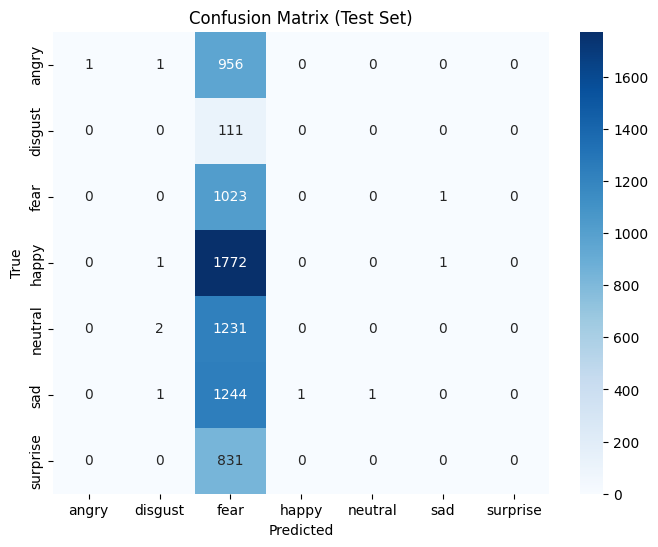

/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

Classification Report (Test Set):
               precision    recall  f1-score   support

       angry       1.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      1.00      0.25      1024
       happy       0.00      0.00      0.00      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.14      7178
   macro avg       0.16      0.14      0.04      7178
weighted avg       0.15      0.14      0.04      7178



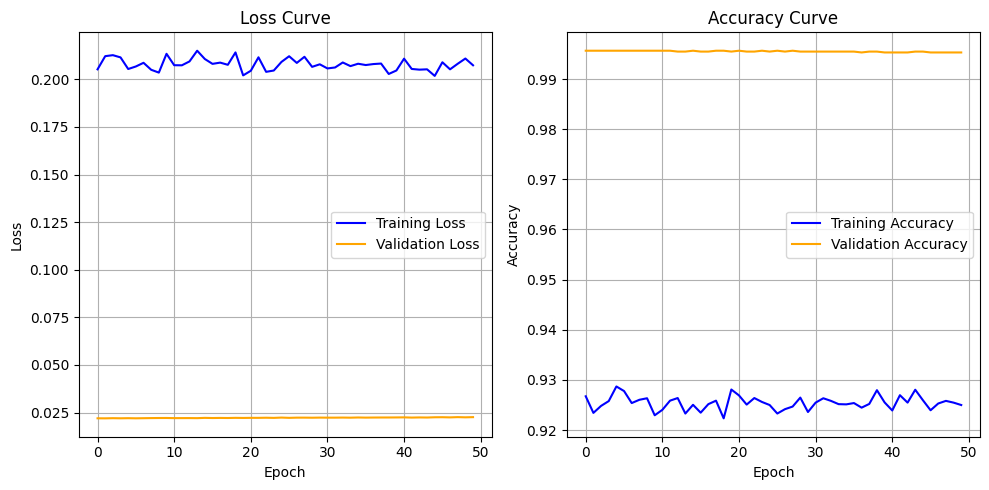

In [ ]:
def plot_training_history(history, model):
    # Final evaluation: Calculate accuracy and loss on the test set
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")

    # Confusion matrix and classification report (using test_dataset)
    # Get true labels
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_true = np.argmax(y_true, axis=1)

    # Predict labels
    y_pred = model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis=1)

    # Check if shapes match
    if len(y_true) != len(y_pred):
        raise ValueError(f"Mismatch between y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths!")

    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix (Test Set):\n", cm)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print("Classification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

    # Plot training curves (unchanged)
    plt.figure(figsize=(10, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history_basic, model_basic)

### Model 2 + Batch Normalization and Dropout

In [ ]:
# Model 2 CNN with Batch Normalization and Dropout
inputs = keras.Input(shape=(48, 48, 1))

# First block
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Second block
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Third block
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Fully connected layer
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # 7 classes

model_normalization = keras.Model(inputs, outputs)

model_normalization.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_normalization.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 256)            │         1,02

 Total params: 3,510,215 (13.39 MB)

 Trainable params: 3,507,911 (13.38 MB)

 Non-trainable params: 2,304 (9.00 KB)

#### Training

In [57]:
# callback to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_model_with_batch_normalization.keras",
        save_best_only=True,
        monitor="val_loss"),
]

# fit the model
history_batch_normalization = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9221 - loss: 0.2140 - val_accuracy: 0.9953 - val_loss: 0.0226
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9276 - loss: 0.2064 - val_accuracy: 0.9953 - val_loss: 0.0226
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9255 - loss: 0.2106 - val_accuracy: 0.9953 - val_loss: 0.0227
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9280 - loss: 0.2095 - val_accuracy: 0.9953 - val_loss: 0.0226
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9249 - loss: 0.2069 - val_accuracy: 0.9953 - val_loss: 0.0227
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9266 - loss: 0.2000 - val_accuracy: 0.9953 - val_loss: 0.0227
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9283 - loss: 0.2041 - val_accuracy: 0.9953 - val_loss: 0.0227
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9257 - loss: 0.2006 - val_accu

#### Plotting

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1811 - loss: 1.9548
Test Loss: 1.9429172277450562
Test Accuracy: 0.23892448842525482
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Confusion Matrix (Test Set):
 [[   1    0    0  678    0  277    2]
 [   0    0    0   72    0   39    0]
 [   0    0    0  701    0  321    2]
 [   0    0    0 1345    0  425    4]
 [   0    0    0  853    0  376    4]
 [   0    1    0  869    1  368    8]
 [   0    0    0  578    0  252    1]]


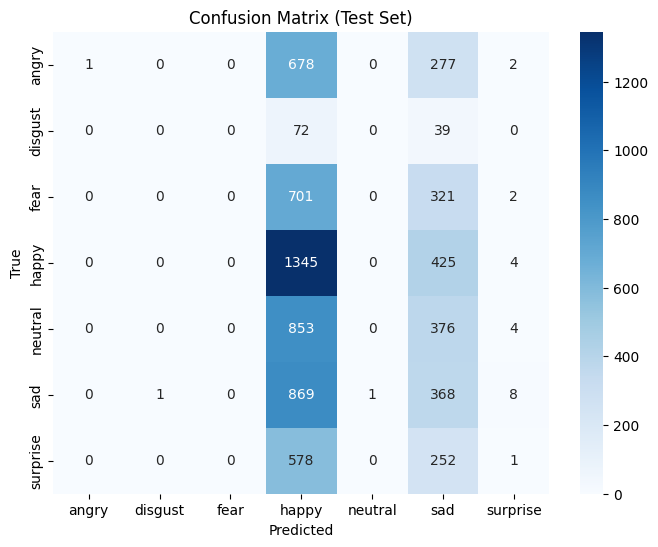

/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

Classification Report (Test Set):
               precision    recall  f1-score   support

       angry       1.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.26      0.76      0.39      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.18      0.30      0.22      1247
    surprise       0.05      0.00      0.00       831

    accuracy                           0.24      7178
   macro avg       0.21      0.15      0.09      7178
weighted avg       0.24      0.24      0.14      7178



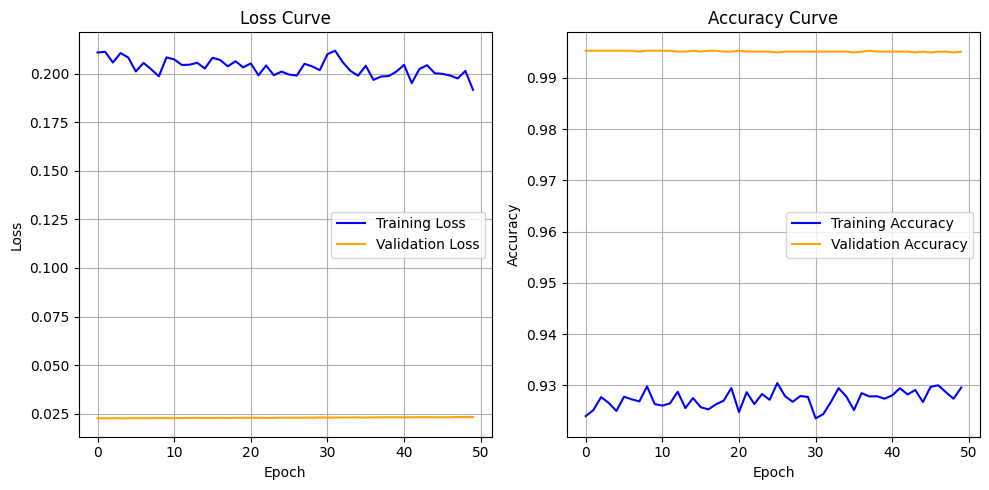

In [ ]:
# Plot training history
plot_training_history(history_batch_normalization, model_normalization)

### Model 3 Batch Normalization with augmentation + SGD + ReduceLROnPlateau

In [ ]:
# Model 3 Batch Normalization with augmentation + SGD
inputs = keras.Input(shape=(48, 48, 1))

# First block
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Second block
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Third block
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Fully connected layer
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # 7 classes

model_augmentation_normalization_SGD = keras.Model(inputs, outputs)

model_augmentation_normalization_SGD.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_augmentation_normalization_SGD.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 256)            │         1,02

 Total params: 3,510,215 (13.39 MB)

 Trainable params: 3,507,911 (13.38 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [60]:
# callback to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_model_augmentation_normalization_SGD.keras",
        save_best_only=True,
        monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# fit the model
history_augmentation_normalization_SGD = model.fit(
    train_dataset_augmentation,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4372 - loss: 2.8695 - val_accuracy: 0.9315 - val_loss: 0.2077 - learning_rate: 2.4414e-06
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4343 - loss: 2.8778 - val_accuracy: 0.9315 - val_loss: 0.2066 - learning_rate: 2.4414e-06
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4410 - loss: 2.8750 - val_accuracy: 0.9308 - val_loss: 0.2072 - learning_rate: 2.4414e-06
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4433 - loss: 2.8187 - val_accuracy: 0.9296 - val_loss: 0.2092 - learning_rate: 2.4414e-06
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4444 - loss: 2.8091 - val_accuracy: 0.9286 - val_loss: 0.2127 - learning_rate: 2.4414e-06
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4444 - loss: 2.8046 - val_accuracy: 0.9293 - val_loss: 0.2102 - learning_rate: 1.2207e-06
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - ac

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.1242 - loss: 1.9430
Test Loss: 1.9453978538513184
Test Accuracy: 0.14711618423461914
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Confusion Matrix (Test Set):
 [[ 67   4 379   6  11 491   0]
 [  4   0  51   0   0  56   0]
 [ 76   3 353   3  10 579   0]
 [138   2 737  12  16 869   0]
 [111   6 449  12  17 638   0]
 [109   3 500  14  14 607   0]
 [ 45   1 242   3   4 536   0]]


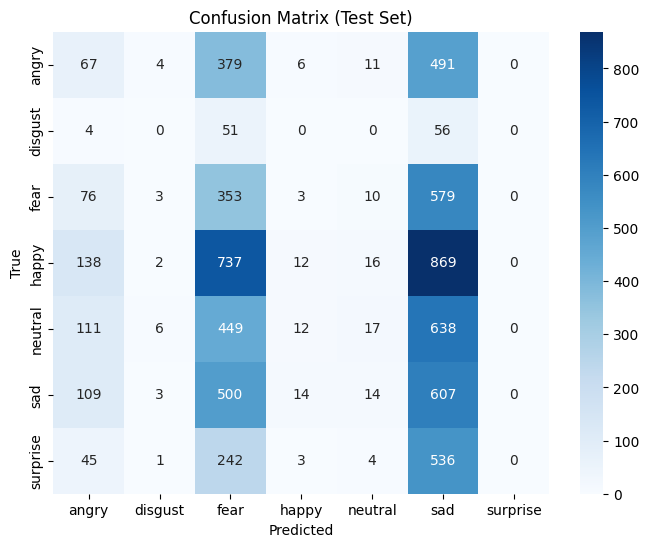

/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

Classification Report (Test Set):
               precision    recall  f1-score   support

       angry       0.12      0.07      0.09       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.34      0.19      1024
       happy       0.24      0.01      0.01      1774
     neutral       0.24      0.01      0.03      1233
         sad       0.16      0.49      0.24      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.15      7178
   macro avg       0.13      0.13      0.08      7178
weighted avg       0.16      0.15      0.09      7178



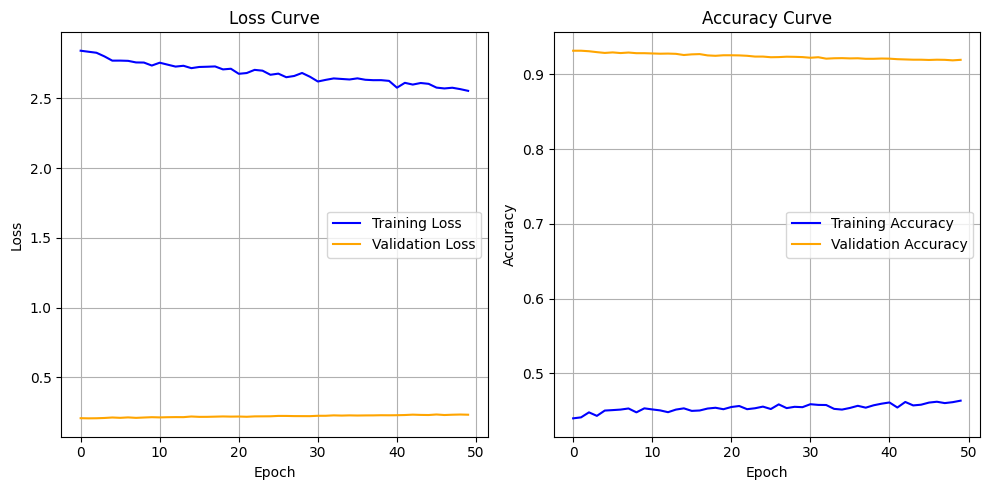

In [ ]:
# Plot training history
plot_training_history(history_augmentation_normalization_SGD, model_augmentation_normalization_SGD)